##### Import necessary modules

In [1]:
#########################################
### Implementing model from Geisler et al 2010
### Place cell maps: Rate based.
#########################################


from numpy import *
from scipy import *
from pylab import *
import matplotlib.cm as cmx 
import matplotlib.colors as colors
from scipy import signal as sg
import numpy as np
from scipy.fftpack import fft
import peakutils.peak as pk

##For colour bar: makecmap.py is in the same folder
import makecmap as mc

##For checking freq is in theta band (4-12 Hz):
import checktheta as ct

##For generating spiketimes:
import spikegen as spg
%matplotlib inline


##### Assume that the animal is running at constant velocity along a linear track. Then firing rate map will have same envelope as place field, but the firing rate is modulated at theta frequency (f0). Experimentally, this frequency can be obtained from the autocorrelation of the neuron's firing rate (f0 = 1/tau_autocorr)

In [2]:
#### Firing Rate maps (in time) or Firing Probabilities for individual cells:

def SingleNeuronRateMap(t, f0=8.6, tau_n=0.075*1, sigma=0.5/sqrt(2), T_n=1):
    '''
    Sigmoidal rate function modulated by Gaussian envelope.
    
    t : Time array

    f0 (=8.6 Hz) : Intrinsic theta frequency/frequency of modulation of single cell firing
    tau_n (=0.075) : Theta phase of neuron
    sigma (=0.5/sqrt(2)) : Half-Width of gaussian envelope
    T_n (=1) : Centre of place field of cell/Time of maximal firing
        
    Gaussian envelope: 1/sqrt(pi*sigma) * exp( -(t-Tn)^2/sigma^2 )
    Firing rate is oscillatory(at freq f0) and phase shift is 2*pi*f0*tau_n
 
    '''
    return ( 1+exp(2j*pi*f0*(t-tau_n)) ) * 1/(sqrt(pi)*sigma)*exp(-(t-T_n)**2/sigma**2)


##### Define Parameters for setting up rate maps for place cells:

In [3]:
############################
#### Parameters:
############################

TotalL = 5.0 #s         # Length of arena (Assuming constant running speed in forward direction)

#### Parameters for ratemap: Homogenous population
L = 1.5 #s              # Place field size in time: L = s*PFS where 
                        # s = running speed, PFS = Place field size in space
f0 = 8.6 #Hz            # Oscillation frequency of single neurons
c = 0.075               # Compression factor
sigma = L/(3*sqrt(2))   # Sigma of gaussian envelope of SNRM [single neuron rate map]

#### Distriuting place field centres
N = 100                            # No. of place cells
Tn = arange(0,TotalL,TotalL/N)    # Place field centres : uniformly distributed

## Time lag tau_n is correlated with position T_n of place-field centres. 
## Experimental: Sigmoidal. Linear for large range.    Model: Related by compression factor.
taun = c*Tn                       # Theta -scale time lag. Depends on compression factor. 
                                  # How separated are 2 place cell's theta phase given their 
                                  # separation in space? Ans:   delta tau_n = c * delta T_n

#### Simulation parameters
delt = 0.001                      # Delta t: time step           
t = arange(0, TotalL, delt)       # Time array


### Setting rate maps for single cells. 

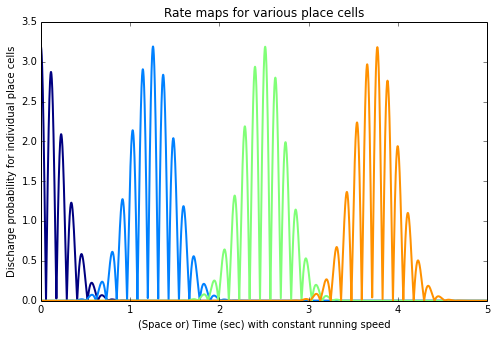

In [5]:
############################
######## Rate maps:
############################

rates = zeros([N, len(t)], dtype=complex)        ### To hold rate maps for all cells
#### Create place cell maps:
for i in xrange(0,N):
    rates[i][:] = SingleNeuronRateMap(t,tau_n=taun[i], T_n = Tn[i], sigma=sigma)
    
    

#############################
####### Plotting:
#############################

#### Plotting rate maps for example cells
num_of_maps = 4                         ### No. of example rate maps
cells_to_plot = range(0, N, int(N/num_of_maps))
colorbar = mc.MakeColourMap(N)

fig1 = figure(figsize=(8,5))
for idx in cells_to_plot:
    line = abs(rates[idx][:])
    colorVal = colorbar.to_rgba(idx)
    plot(t, line, color=colorVal, linewidth=2.0)       #Add label if you want legend.

ylabel('Discharge probability for individual place cells')
xlabel('(Space or) Time (sec) with constant running speed')
title('Rate maps for various place cells')

### Population rate is sum of individual neuron rate maps.

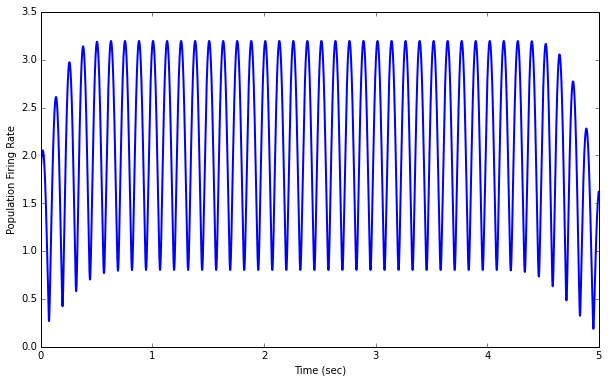

In [6]:
#### Population activity:
nfactor = 2*(Tn[1] - Tn[0])                      ### Normalization factor
poprate = np.sum(rates,0)*nfactor                ### Population rate

fig2=figure(figsize=(2*TotalL,6))
plot(t, abs(poprate), color='b', linewidth=2.0)
xlabel('Time (sec)')
ylabel('Population Firing Rate')


### Finding frequency of oscillation (in the theta band) for single neuron and population rate

In [7]:
### Power spectrum of rate maps:

ns = len(poprate)
pop_fft = fft(poprate)                                     # Population rate FFT
cell_fft = fft(rates[N/2][:])                               # FFT for a single neuron rate map
freq = np.arange(0.0,1.0/(2*delt),1.0/(2*delt)*2/ns)    # Frequency array (0 to fmax)   



### Now let's plot the power spectrum!

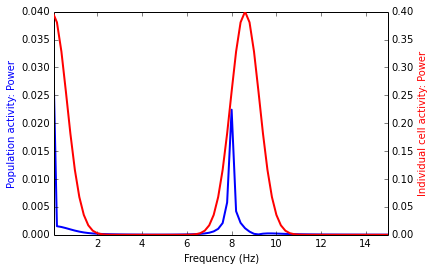

In [8]:
fig3=figure()
A = fig3.add_subplot(111)
A.plot(freq,2.0/ns*abs(pop_fft[0:ns/2])/N, color ='b' , linewidth = 2.0)
B = A.twinx()             # Same x-axis, different scales on y-axis
B.plot(freq,2.0/ns*abs(cell_fft[0:ns/2]), 'r-' , linewidth =2.0)
A.set_xlim([0.05, 15])    # Plot upto freq = 15Hz
A.set_ylabel('Population activity: Power', color='b' )
A.set_xlabel('Frequency (Hz)')
B.set_ylabel('Individual cell activity: Power', color ='r')

### Find the frequency in the theta band with maximum power.

In [9]:
### Protocol for finding frequency with peak power:
### Finding local peaks ( and above threshold = 20% Peak power)
### pk.indexes returns the "indices" of the local peaks
LFP_freq = pk.indexes(abs(pop_fft[0:ns/2]), thres=0.2)          #Indices of local maximas in power spectrum of poprate
Intrinsic_freq = pk.indexes(abs(cell_fft[0:ns/2]), thres=0.2)   #Indices of local maximas in power spectrum of cell rates


### What is the frequency (in theta band) at which single neuron or population activity is modulated? 
### Theta band used: 4-12 Hz

## LFP
LFP_Theta = ct.CheckThetaFreq( LFP_freq, freq )
if LFP_Theta>12:
    print 'No Peak in Theta Band for population activity'
else:
    print 'Population rate is modulated at frequency', LFP_Theta, 'Hz'
    
## Individual cells
Intrinsic_Theta = ct.CheckThetaFreq( Intrinsic_freq, freq )
if Intrinsic_Theta < 12:
    print 'Individual cell firing rate is modulated at frequency', Intrinsic_Theta, 'Hz'
else:
    print 'No Peak in Theta Band for individual cell activity'

Population rate is modulated at frequency 8.0 Hz
Individual cell firing rate is modulated at frequency 8.6 Hz


### Superimpose firing rate peaks of individual cells on population rate

In [10]:
example_cells = [int(0.35*N), int(0.65*N)]

peak_times = {}
threshold = 0.2     ## Minimum normalized peak size to be detected
# Detecting peaks in firing rates
for ii in example_cells:
    pks = sg.argrelextrema(abs(rates[ii][:]), np.greater)
    thresh_pk = threshold * max(abs(rates[ii]))             #Minimum peak size
    idx = where(abs(rates[ii][pks]) >= thresh_pk)
    peak_times[ii] = pks[0][idx[0]]
    
    


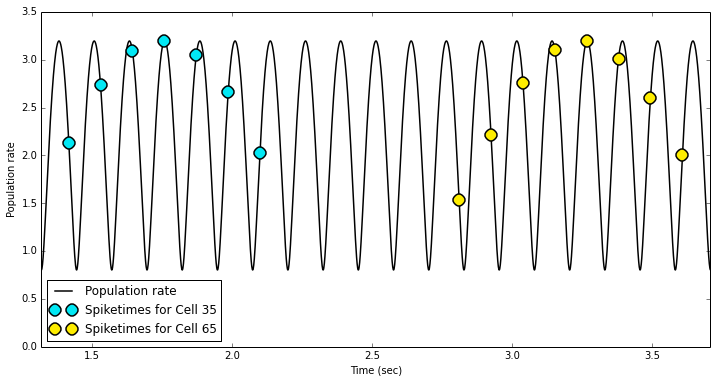

In [11]:
### X-axis limits based on plotted spiketimes
mintime = t[ peak_times[example_cells[0]][0] ]     # First spike
maxtime = t[ peak_times[example_cells[-1]][-1] ]   # Last spike


### Plotting:
fig4 = figure(figsize=(12,6))
# Plot population rate for reference
plot(t, abs(poprate), color='k', label='Population rate', linewidth=1.5)
#Plot peaks for example cells
for idx in example_cells:
    colorVal=colorbar.to_rgba(idx)
    ptimes = peak_times[idx]
    plot(t[ptimes], abs(poprate[ptimes]), 'ro', color=colorVal, markersize=12.0, markeredgecolor='k', markeredgewidth=1.5, label='Spiketimes for Cell {}'.format(idx) )
xlabel('Time (sec)')
xlim([mintime-100*delt, maxtime+100*delt])
ylabel('Population rate')
legend(loc=3)

# Let's examine the phase precession

### Finding phase wrt Population Theta Oscillations

In [179]:
## Demonstration: If LFP has no theta peak, work with a dummy theta.
if LFP_Theta > 12:
    LFP_Theta = f0*(1-c)
        
### Define phase wrt LFP theta oscillations

# Find first population trough to set as phase 0.
skip = int(1.0/delt)  #Skip initial 1.0s to avoid edge effects
pop_troughs = sg.argrelextrema(poprate[skip:], np.less)

### Now that you have population rate troughs, you can calculate phase in each cycle wrt to 
### distance between successive troughs. This is useful when your power spectrum does not show a
### single strong peak in the theta band.
### For this tutorial, we will assume a a constant frequency oscillation. Thus, the first trough 
### can be used to set all phases
pop_phase0 = pop_troughs[0][0]                # because the fn argrel... returns tuple of arrays
phase = mod(2*pi*LFP_Theta*(t-t[pop_phase0+skip]), 2*pi)      # Array with LFP phase


### Assignment: Measure phase within each cycle by representing the trough to trough interval in that cycle as phase 0 to 360 degrees, instead of measuring it using the sinusoid.



### Hint: Use scipy.signal.argrelextrema

### How does the phase of the peaks in rate map vary?

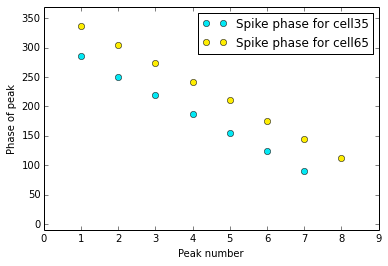

In [180]:
xhigh = max(len(peak_times[idx]) for idx in example_cells)

## Plot phase of successive peaks
fig5=figure()
for idx in example_cells:
    colorVal = colorbar.to_rgba(idx)
    ptimes = peak_times[idx]
    numspikes = len(ptimes)
    plot(range(1,numspikes+1), phase[ptimes]*180/pi, 'ro',  color=colorVal,label='Spike phase for cell{}'.format(idx))
xlabel('Peak number')
ylabel('Phase of peak')
xlim([0, xhigh+1])
ylim([-10, 370])
legend()


### Assignment: Measure the slope of phase precession. How does it change with parameters like c, f0, ...? Why?

### How does the firing rate correlate with spike phase?

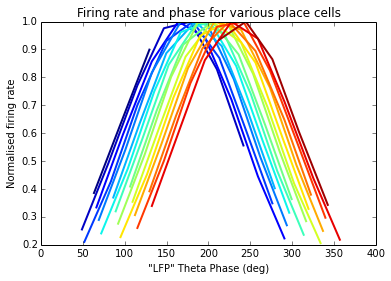

In [181]:
### New set of example cells
example_cells2=range(0,N,N/15)
peak_times2 = {}
threshold2 = 0.2     ## Minimum normalized peak size to be detected

# Detecting peaks in firing rates
for ind in example_cells2:
    pks = sg.argrelextrema(abs(rates[ind][:]), np.greater)
    thresh_pk = threshold * max(abs(rates[ind][:]))                 #Minimum peak size
    idx = where(abs(rates[ind][pks]) >= thresh_pk)
    peak_times2[ind] = pks[0][idx[0]]
    
    
fig6 = figure()

for idx in example_cells2:
    colorVal=colorbar.to_rgba(idx)
    maxrate = amax(abs(rates[idx][:]))
    ptimes = peak_times2[idx]
    plot( phase[ptimes]*180/pi, abs(rates[idx][ptimes])/maxrate, color=colorVal, linewidth=2.0)
xlabel('"LFP" Theta Phase (deg)')
ylabel('Normalised firing rate')
title('Firing rate and phase for various place cells')

# Generating spikes

### Use the rate map to generate spiketimes for different cells

In [182]:
maxFR = 20        #Hz ()Max instantaneous firing rate
threshold = 0.25
trials = 500
spiketimes ={}
TimePeriod = 1/LFP_Theta     #in sec

spiking_cell = N/2
for ii in range(trials):
    spiketimes[ii] = spg.GenerateSpikeTimes(abs(rates[spiking_cell][:]), t, ns, delt, maxFR, threshold)

## Raster plot
## ???
##

### Setting x-limits
xlow=max(t)
xhigh=0

##To trap for empty trials
for ii in range(trials):
    if len(spiketimes[ii])>0:
        xlow=min(xlow, t[spiketimes[ii][0]])
        xhigh=max(xhigh, t[spiketimes[ii][-1]])
xlow=xlow-TimePeriod
xhigh=xhigh+TimePeriod

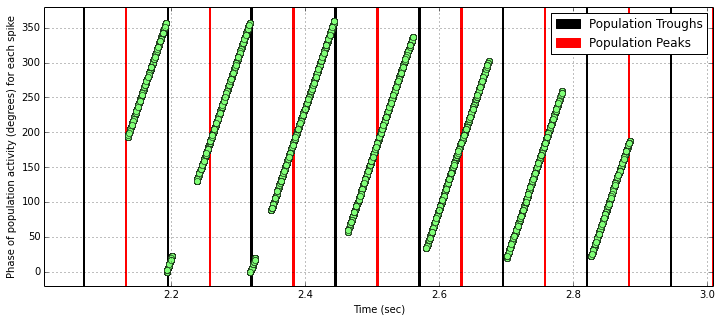

In [183]:
## Phase of spikes:
## Find Pop troughs and peaks:
troughs =  arange(-3*TimePeriod+t[pop_phase0], max(t), TimePeriod)
peaks = arange(-2.5*TimePeriod+t[pop_phase0], max(t), TimePeriod)
colorVal=colorbar.to_rgba(spiking_cell)

### Plotting phases if spikes
fig7=figure(figsize=(12,5))
ax=fig7.add_subplot(111)
for ii in range(trials):
    plot(t[spiketimes[ii]], phase[[spiketimes[ii]]]*180/pi , 'ro', color=colorVal)
bar(troughs,[400 for jj in troughs], bottom=[-20 for jj in troughs], width=2*delt, color='k', label='Population Troughs')
bar(peaks,height=[400 for jj in peaks], bottom=[-20 for jj in peaks], width=2*delt, color='r', edgecolor='r', label='Population Peaks')
ax.grid()
xlim([xlow,xhigh])
ylim([-20,380])
xlabel('Time (sec)')
ylabel('Phase of population activity (degrees) for each spike')
legend()

### Assignment: Measure phase of first spike and mean phase within each theta cycle. 
### How does it change with time(cycle number)? Do both vary identically?

### Plot histogram of spiketimes

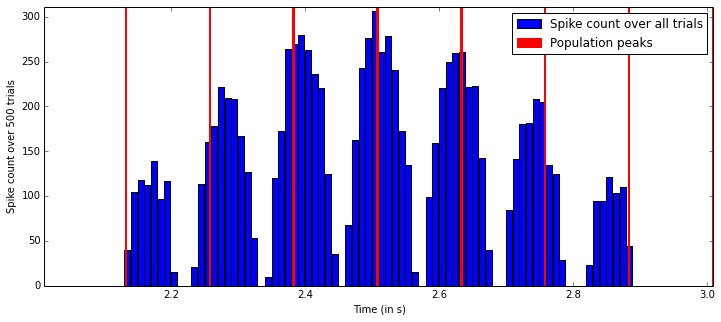

In [184]:
#### Creating histogram:
#### Bins for histogram of spike times for spk_cells
numofbins=100
bins = arange(xlow, xhigh, (xhigh-xlow)/numofbins)
[spikecount,b] = histogram(t[spiketimes[0]], bins)
count = spikecount

for ii in xrange(1,trials):
    [spikecount,b] = histogram(t[spiketimes[ii]], bins)
    count += spikecount   
yhigh=max(count)+5

fig8=figure(figsize=(12,5))
## Histogram of spike times for example cell:
bar(bins[:-1], count, width=(bins[1]-bins[0])*0.9, label='Spike count over all trials')
## Theta peaks and troughs:
#bar(troughs, [yhigh for jj in troughs],  width=delt ,color='k', edgecolor='k', label='Population troughs')
bar(peaks, [yhigh for jj in peaks],  width=2*delt ,color='r', edgecolor='r', label='Population peaks')
xlim(xlow,xhigh)
ylim([0, yhigh])
xlabel('Time (in s)')
ylabel('Spike count over %d trials'%(trials))
legend()

 * Firing rate changes within the place field : Gaussian envelope


 * Spiking is theta-modulated


 * Spiking phase decreases in later part of place field (or here, in successive theta cycles)


#### But...
 
#### Experimentally, spiking phase is more correlated with location within the place field rather than time or number of theta cycles passed since entering place field

### Assignment:
* Generate spikes for all cells
* Calculate population activity from spike trains of all cells: Remember ML tutorial ?!
* Find power in theta band for population activity. Where is the peak?
* Plot phase of spikes for different cells versus time/cycle number.
* Analyse firing rate and phase precession for different cells.

## Heterogenous population of place cells

In [225]:
## Use same PF centres, but change widths, intrinsic frequency, compression factor, tau_n

L = 1/(8.7)+3+rand(N)*5     # Place field size : Between 3.x and 8.x second, x=1/8.7
                            # (Assuming constant running speed in forward direction)

sigma = L/(3*sqrt(2))       # Sigma of gaussian envelope of PF
f0 = 8.6 - 1/L #Hz          # Oscillation frequency of single neurons: Use diff distributions.
                            # Here, dependent on L. (L and f0 co-vary across EC layers and dorsoventrally)
c = 1/multiply(L,f0)        # Compression factor: L*c*f0 = 1
taun = multiply(c,Tn)       #Theta -scale time lag    

rates = zeros([N, len(t)], dtype=complex)
#### Create place cell maps:
for i in xrange(0,N):
    rates[i][:] = SingleNeuronRateMap(t,f0=f0[i],tau_n=taun[i], T_n = Tn[i], sigma=sigma[i])
    
### Get population activity:
poprate = np.sum(rates,0)*nfactor



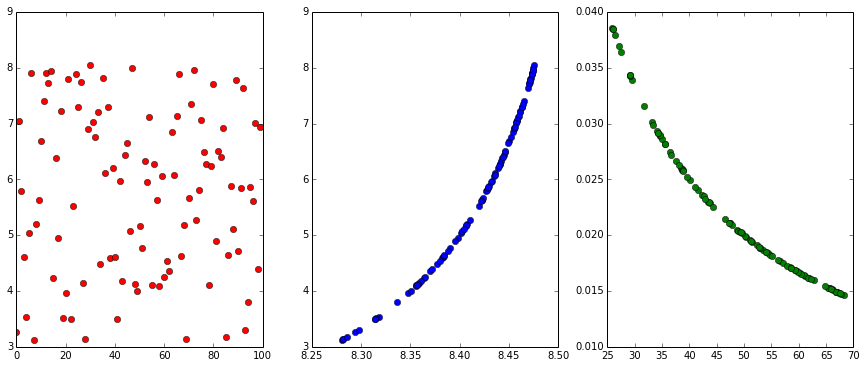

In [226]:
fig7a=figure(figsize=(15,6))
subplot(131)
plot(range(N), L, 'ro')
subplot(132)
plot(f0,L,'bo')
subplot(133)
plot(multiply(L,f0),c,'go')

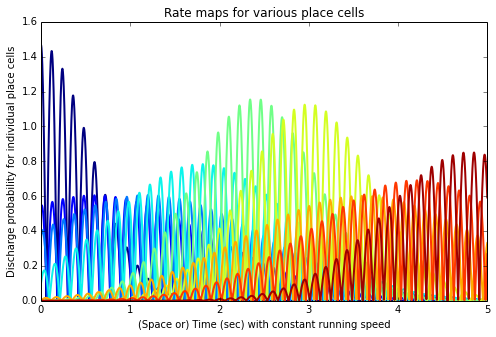

In [227]:
#### Plotting rate maps for example cells
num_of_maps = 8                         ### No. of example rate maps
cells_to_plot = range(0, N, int(N/num_of_maps))
colorbar = mc.MakeColourMap(N)

fig1 = figure(figsize=(8,5))
for idx in cells_to_plot:
    line = abs(rates[idx][:])
    colorVal = colorbar.to_rgba(idx)
    plot(t, line, color=colorVal, linewidth=2.0)       #Add label if you want legend.

ylabel('Discharge probability for individual place cells')
xlabel('(Space or) Time (sec) with constant running speed')
title('Rate maps for various place cells')

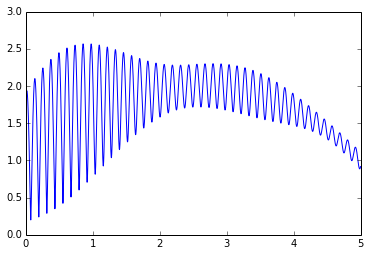

In [228]:
### Plot poprate
fig7b=figure()
plot(t,abs(poprate))

### Generating spikes to observe phase precession

In [229]:
### Spiking cells:
### Generate spikes. Plot phase versus 

maxFR = 20        #Hz ()Max instantaneous firing rate
threshold = 0.25
trials = 500
spiketimes ={}
TimePeriod = 1/LFP_Theta     #in sec

spiking_cell = N/2
for ii in range(trials):
    spiketimes[ii] = spg.GenerateSpikeTimes(abs(rates[spiking_cell][:]), t, ns, delt, maxFR, threshold)

## Raster plot
## ???
##

### Setting x-limits
xlow=max(t)
xhigh=0

##To trap for empty trials
for ii in range(trials):
    if len(spiketimes[ii])>0:
        xlow=min(xlow, t[spiketimes[ii][0]])
        xhigh=max(xhigh, t[spiketimes[ii][-1]])
xlow=xlow-TimePeriod
xhigh=xhigh+TimePeriod

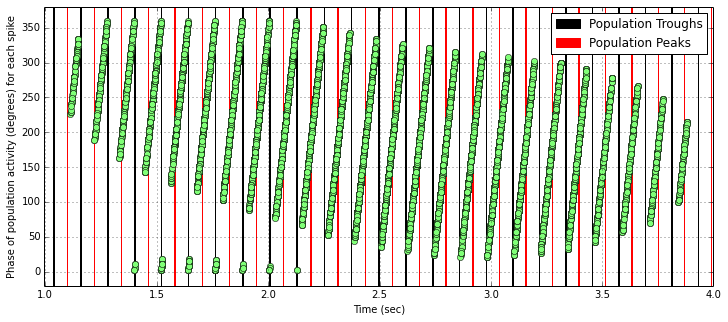

In [230]:
## Phase of spikes:
## Find Pop troughs and peaks:
trs =sg.argrelextrema(abs(poprate), np.less)
pks =sg.argrelextrema(abs(poprate), np.greater)
troughs =  t[trs]
peaks = t[pks]

cell_phase={}
### Getting phase from population troughs:
for ii in range(trials):
    cell_phase[ii] = []
    for jj in range(len(spiketimes[ii])):
        tr_next=searchsorted(troughs, t[spiketimes[ii][jj]])
        tr_prev=tr_next-1
        cell_phase[ii].append( (t[spiketimes[ii][jj]] - troughs[tr_prev] )*360/(troughs[tr_next] -troughs[tr_prev]))
        
### Plotting phases if spikes
colorVal=colorbar.to_rgba(spiking_cell)
fig7=figure(figsize=(12,5))
ax=fig7.add_subplot(111)
for ii in range(trials):
    plot(t[spiketimes[ii]], cell_phase[ii] , 'ro', color=colorVal)
bar(troughs,[400 for jj in troughs], bottom=[-20 for jj in troughs], width=2*delt, color='k', label='Population Troughs')
bar(peaks,height=[400 for jj in peaks], bottom=[-20 for jj in peaks], width=2*delt, color='r', edgecolor='r', label='Population Peaks')
ax.grid()
xlim([xlow,xhigh])
ylim([-20,380])
xlabel('Time (sec)')
ylabel('Phase of population activity (degrees) for each spike')
legend()

In [231]:
### Power spectrum of population activity

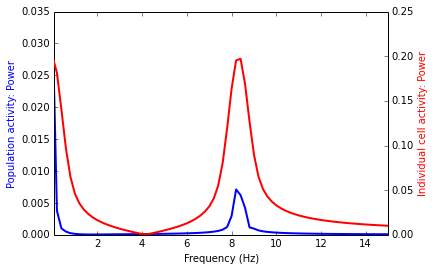

In [232]:
### Power spectrum of rate maps: Population and example cell

ns = len(poprate)
pop_fft = fft(poprate)                                     # Population rate FFT
cell_fft = fft(rates[0][:])                               # FFT for a single neuron rate map
freq = np.arange(0.0,1.0/(2*delt),1.0/(2*delt)*2/ns)    # Frequency array (0 to fmax)   

fig3=figure()
A = fig3.add_subplot(111)
A.plot(freq,2.0/ns*abs(pop_fft[0:ns/2])/N, color ='b' , linewidth = 2.0)
B = A.twinx()             # Same x-axis, different scales on y-axis
B.plot(freq,2.0/ns*abs(cell_fft[0:ns/2]), 'r-' , linewidth =2.0)
A.set_xlim([0.05, 15])    # Plot upto freq = 15Hz
A.set_ylabel('Population activity: Power', color='b' )
A.set_xlabel('Frequency (Hz)')
B.set_ylabel('Individual cell activity: Power', color ='r')

In [233]:
### Protocol for finding frequency with peak power:
### Finding local peaks ( and above threshold = 20% Peak power)
### pk.indexes returns the "indices" of the local peaks
LFP_freq = pk.indexes(abs(pop_fft[0:ns/2]), thres=0.15)          #Indices of local maximas in power spectrum of poprate
Intrinsic_freq = pk.indexes(abs(cell_fft[0:ns/2]), thres=0.15)   #Indices of local maximas in power spectrum of cell rates


### What is the frequency (in theta band) at which single neuron or population activity is modulated? 
### Theta band used: 4-12 Hz

## LFP
LFP_Theta = ct.CheckThetaFreq( LFP_freq, freq )
if LFP_Theta>12:
    print 'No Peak in Theta Band for population activity'
else:
    print 'Population rate is modulated at frequency', LFP_Theta, 'Hz'
    
## Individual cells
Intrinsic_Theta = ct.CheckThetaFreq( Intrinsic_freq, freq )
if Intrinsic_Theta < 12:
    print 'Individual cell firing rate is modulated at frequency', Intrinsic_Theta, 'Hz'
else:
    print 'No Peak in Theta Band for individual cell activity'

Population rate is modulated at frequency 8.2 Hz
Individual cell firing rate is modulated at frequency 8.4 Hz


### Assignment: Find power spectrum and frequency of modulation for each cell. Compare against set parameter f0.